## Step 1: Import Libraries

In [27]:
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Set plot styles
sns.set(style="whitegrid")

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Step 2: Set Up Logging

In [28]:
# Set up the logger
logging.basicConfig(filename='data_cleaning_and_analysis.log', 
                    level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

logger = logging.getLogger()
logger.info("Logger initialized and ready to log the steps.")

# Step 3: Define Custom Transformers for the Pipeline

In [29]:
# Transformer for handling missing values
class HandleMissingValues(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        logger.info("Handling missing values...")

        X['CompetitionDistance'].fillna(X['CompetitionDistance'].median(), inplace=True)
        logger.info("Filled 'CompetitionDistance' missing values with median.")

        X['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
        X['CompetitionOpenSinceYear'].fillna(0, inplace=True)
        logger.info("Filled 'CompetitionOpenSinceMonth' and 'CompetitionOpenSinceYear' with 0.")

        X['Promo2SinceWeek'].fillna(0, inplace=True)
        X['Promo2SinceYear'].fillna(0, inplace=True)
        X['PromoInterval'].fillna('None', inplace=True)
        logger.info("Filled promo-related missing values with default values.")

        X['Open'].fillna(0, inplace=True)
        logger.info("Filled 'Open' missing values with 0.")

        return X

# Transformer for handling outliers
class HandleOutliers(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        self.medians = {}
        self.bounds = {}
        for column in self.columns:
            Q1 = X[column].quantile(0.25)
            Q3 = X[column].quantile(0.75)
            IQR = Q3 - Q1
            self.bounds[column] = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
            self.medians[column] = X[column].median()
        return self
    
    def transform(self, X):
        logger.info("Handling outliers...")
        for column in self.columns:
            lower_bound, upper_bound = self.bounds[column]
            median = self.medians[column]
            X[column] = np.where((X[column] < lower_bound) | (X[column] > upper_bound), median, X[column])
            logger.info(f"Replaced outliers in '{column}' with median.")
        return X

# Transformer for feature engineering
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        logger.info("Performing feature engineering...")

        X['CompetitionOpenSinceDate'] = pd.to_datetime(
            dict(year=X['CompetitionOpenSinceYear'], 
                 month=X['CompetitionOpenSinceMonth'], 
                 day=1),
            errors='coerce'
        )
        X['CompetitionOpenSinceDate'].fillna(0, inplace=True) # handle if any missing value generate here
        logger.info("Created 'CompetitionOpenSinceDate'.")

        X['Date'] = pd.to_datetime(X['Date'])
        X['Year'] = X['Date'].dt.year
        X['Month'] = X['Date'].dt.month
        X['Day'] = X['Date'].dt.day
        X['WeekOfYear'] = X['Date'].dt.isocalendar().week
        X['DayOfWeek'] = X['Date'].dt.dayofweek

        logger.info("Extracted date-related features: Year, Month, Day, WeekOfYear, DayOfWeek.")
        return X

# Step 4: Load and Merge Datasets

In [30]:
# Load The zip file here and extract them to get dataset
import zipfile
zip_ext = zipfile.ZipFile('rossmann-store-sales.zip','r')
zip_ext.extractall('Pharmaceutical_Sales_prediction_dataset')
zip_ext.close()

In [31]:
# Load datasets
logger.info("Loading datasets...")

try:
    train = pd.read_csv('Pharmaceutical_Sales_prediction_dataset//train.csv')
    store = pd.read_csv('Pharmaceutical_Sales_prediction_dataset//store.csv')
    test = pd.read_csv('Pharmaceutical_Sales_prediction_dataset//test.csv')
    sample_submission = pd.read_csv('Pharmaceutical_Sales_prediction_dataset//sample_submission.csv')
    logger.info("Datasets loaded successfully.")
except Exception as e:
    logger.error(f"Error loading datasets: {e}")

# Log dataset shapes
logger.info(f"train dataset shape: {train.shape}")
logger.info(f"store dataset shape: {store.shape}")
logger.info(f"test dataset shape: {test.shape}")
logger.info(f"sample_submission dataset shape: {sample_submission.shape}")

# Merge datasets
try:
    train_store = pd.merge(train, store, how='left', on='Store') #merge train and store dataset
    test_store = pd.merge(test, store, how='left', on='Store') #merge test and store dataset
    test_store = pd.merge(test_store,sample_submission,how='left',on='Id') #merge test_store and sample_submission
    logger.info("Datasets merged successfully.")
except Exception as e:
    logger.error(f"Error merging datasets: {e}")

# Log merged dataset shapes
logger.info(f"train_store dataset shape: {train_store.shape}")
logger.info(f"test_store dataset shape: {test_store.shape}")

In [32]:
# check few rows of dataset
sample_submission.sample(5)

,Id,Sales
38837,38838,0
38144,38145,0
31207,31208,0
35952,35953,0
6355,6356,0


In [33]:
# check few rows of dataset
store.sample(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
392,393,d,c,4820.0,3.0,2008.0,0,NaN,NaN,NaN
497,498,a,a,990.0,NaN,NaN,1,40.0,2014.0,"Jan,Apr,Jul,Oct"
51,52,d,c,450.0,4.0,2014.0,1,39.0,2010.0,"Jan,Apr,Jul,Oct"
9,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN
368,369,d,c,5870.0,4.0,2014.0,0,NaN,NaN,NaN


In [34]:
# check few rows of dataset
train.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
228105,646,4,2015-01-08,5854,810,1,1,0,0
514710,366,4,2014-03-27,4781,558,1,0,0,0
963230,656,1,2013-02-18,3714,448,1,1,0,0
943758,139,4,2013-03-07,6411,556,1,1,0,0
193313,419,7,2015-02-08,0,0,0,0,0,0


In [35]:
train['StateHoliday'].value_counts()

StateHoliday
0    855087
0    131072
a     20260
b      6690
c      4100
Name: count, dtype: int64

In [36]:
# check few rows of dataset
test.sample(5)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
12589,12590,782,4,2015-09-03,1.0,1,0,1
1478,1479,805,3,2015-09-16,1.0,1,0,0
12162,12163,233,4,2015-09-03,1.0,1,0,1
3800,3801,493,7,2015-09-13,0.0,0,0,0
16800,16801,695,6,2015-08-29,1.0,0,0,0


In [37]:
# check nan values
train_store.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

In [38]:
# check nan values
test_store.isnull().sum()

Id                               0
Store                            0
DayOfWeek                        0
Date                             0
Open                            11
Promo                            0
StateHoliday                     0
SchoolHoliday                    0
StoreType                        0
Assortment                       0
CompetitionDistance             96
CompetitionOpenSinceMonth    15216
CompetitionOpenSinceYear     15216
Promo2                           0
Promo2SinceWeek              17232
Promo2SinceYear              17232
PromoInterval                17232
Sales                            0
dtype: int64

## Step 5: Build and Apply the Preprocessing Pipeline

In [39]:
# Define the preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('missing_values', HandleMissingValues()),
    ('outliers', HandleOutliers(columns=['Sales','CompetitionDistance'])),
    ('feature_engineering', FeatureEngineering())
    ])

# Apply the preprocessing pipeline
try:
    train_store = preprocessing_pipeline.fit_transform(train_store)
    test_store = preprocessing_pipeline.transform(test_store)    
    logger.info("Preprocessing pipeline applied successfully.")
except Exception as e:
    logger.error(f"Error applying preprocessing pipeline: {e}")

# Log processed dataset shapes
logger.info(f"Processed train_store dataset shape: {train_store.shape}")
logger.info(f"Processed test_store dataset shape: {test_store.shape}")

In [40]:
# Checke if missing values handled or not
train_store.isnull().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
CompetitionOpenSinceDate     0
Year                         0
Month                        0
Day                          0
WeekOfYear                   0
dtype: int64

In [41]:
# Checke if missing values handled or not
test_store.isnull().sum()

Id                           0
Store                        0
DayOfWeek                    0
Date                         0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
Sales                        0
CompetitionOpenSinceDate     0
Year                         0
Month                        0
Day                          0
WeekOfYear                   0
dtype: int64

All the missing values are handled

# Step 6: Perform EDA with Visualizations

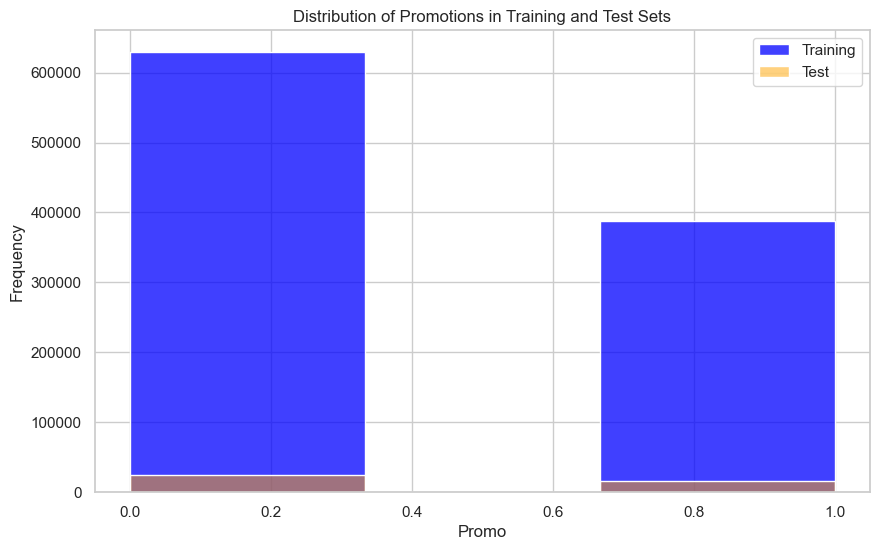

In [43]:
# Function to check promo distribution in training and test sets
def analyze_promo_distribution(train, test):
    logger.info("Analyzing distribution of promotions in training and test sets...")
    try:
        plt.figure(figsize=(10, 6))
        sns.histplot(train['Promo'], label='Training', kde=False, bins=3, color='blue')
        sns.histplot(test['Promo'], label='Test', kde=False, bins=3, color='orange', alpha=0.5)
        plt.title('Distribution of Promotions in Training and Test Sets')
        plt.xlabel('Promo')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()
        logger.info("Plotted distribution of promotions in training and test sets.")
    except Exception as e:
        logger.error(f"Error plotting distribution of promotions: {e}")

# Apply analysis function
try:
    analyze_promo_distribution(train_store, test_store)
    logger.info("Graph formed successfully.")
except Exception as e:
    logger.error(f"Error during EDA: {e}")

### The graph shows the distribution of promotions in both the training and test sets. Here are the key points:

Promotion Frequency:
The x-axis represents the “Promo” values, ranging from 0.0 to 1.0.
The y-axis represents the “Frequency,” with values ranging from 0 to 600,000.
Training Set:
There is a tall blue bar at the 0.0 mark on the x-axis, indicating a high frequency count close to 600,000.
This suggests that promotions are not given frequently or are rare within the training dataset.
Test Set:
The test set also has a blue bar at the same position (0.0), but it is much shorter, indicating a lower frequency count (around 100,000).
#### Again, promotions are relatively infrequent in the test dataset.
### Overall, this graph highlights that promotions occur rarely in both the training and test datasets.

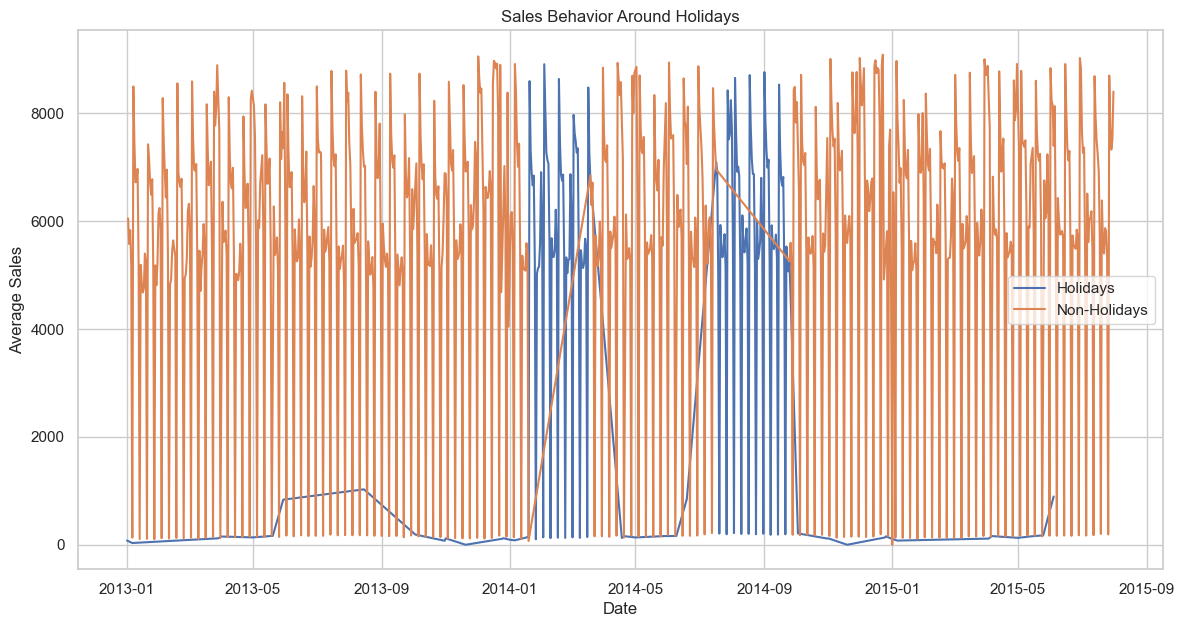

In [44]:
# Function to analyze sales behavior around holidays
def analyze_holiday_sales_behavior(data):
    logger.info("Analyzing sales behavior around holidays...")
    try:
        holidays = data[data['StateHoliday'] != '0']
        non_holidays = data[data['StateHoliday'] == '0']

        plt.figure(figsize=(14, 7))
        sns.lineplot(data=holidays.groupby('Date')['Sales'].mean(), label='Holidays')
        sns.lineplot(data=non_holidays.groupby('Date')['Sales'].mean(), label='Non-Holidays')
        plt.title('Sales Behavior Around Holidays')
        plt.xlabel('Date')
        plt.ylabel('Average Sales')
        plt.legend()
        plt.show()
        logger.info("Plotted sales behavior around holidays.")
    except Exception as e:
        logger.error(f"Error plotting sales behavior around holidays: {e}")
        
# Apply analysis function
try:
    analyze_holiday_sales_behavior(train_store)
    logger.info("Graph formed successfully.")
except Exception as e:
    logger.error(f"Error during EDA: {e}")

### The graph here shows the behavior of average sales around holidays. The analysis is below:

The y-axis represents “Average Sales.”
The x-axis represents “Date,” ranging from early 2013 to late 2015.
There are two lines on the graph:
The orange line represents sales during “Holidays.”
The blue line represents sales during “Non-Holidays.”
Notable observations:
Sales tend to increase around holiday periods (as indicated by spikes in the orange line).
Non-holiday sales remain relatively consistent.
### Overall, this suggests that businesses experience higher sales during holiday seasons.

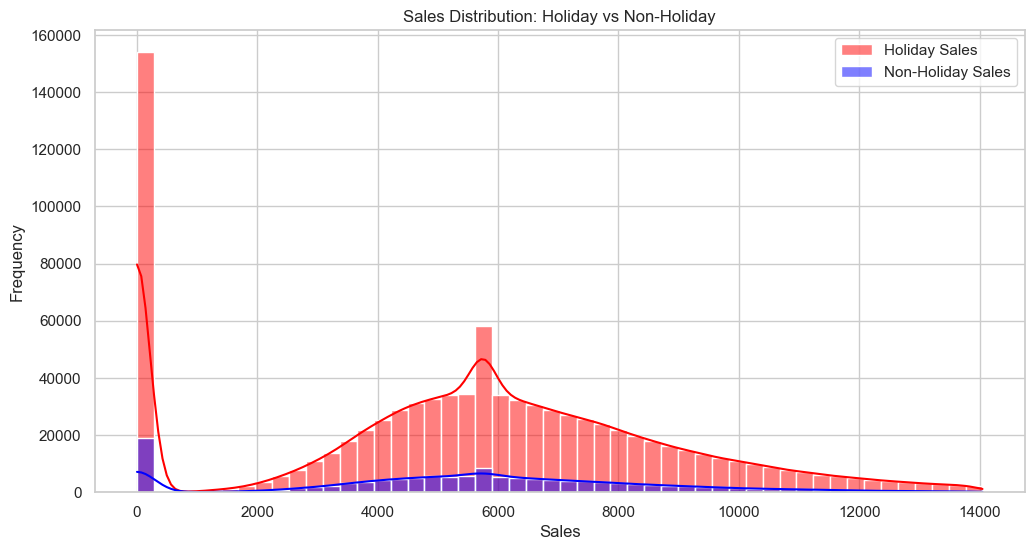

In [45]:
# Compare sales behavior before, during, and after holidays
#train_store['StateHoliday'] = train_store['StateHoliday'].replace({'0': 'None'})
holiday_sales = train_store[train_store['StateHoliday'] != 0]
non_holiday_sales = train_store[train_store['StateHoliday'] == 0]

plt.figure(figsize=(12, 6))
sns.histplot(holiday_sales['Sales'], bins=50, kde=True, label='Holiday Sales', color='red')
sns.histplot(non_holiday_sales['Sales'], bins=50, kde=True, label='Non-Holiday Sales', color='blue')
plt.title('Sales Distribution: Holiday vs Non-Holiday')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### The graph compares the distribution of sales during holiday and non-holiday periods. Here are the key observations:

### Holiday Sales Distribution (Red Histogram):
The peak of the holiday sales distribution occurs near the lower end of the sales axis (around 2000 to 4000 units).
This suggests that during holidays, there are more frequent low-value sales.
### Non-Holiday Sales Distribution (Blue Histogram):
The non-holiday sales distribution is more spread out, covering a wider range of sales values.
The peak frequency for non-holiday sales is lower than that of holiday sales.
Non-holiday periods experience a broader range of sale values but with less frequency at any given point.
### Overall Implications:
Businesses can use this information to understand consumer behavior and plan inventory and staffing needs.
During holidays, expect more frequent low-value sales, while non-holiday periods have a broader range of sales values.

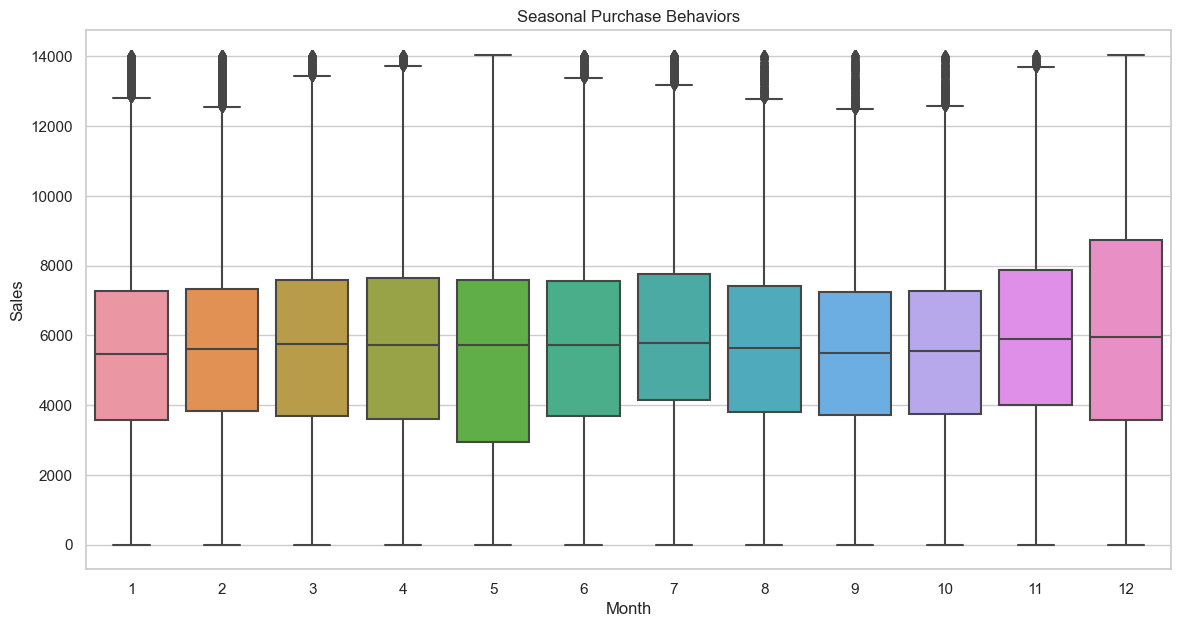

In [46]:
# Function to analyze seasonal purchase behaviors
def analyze_seasonal_behaviors(data):
    logger.info("Analyzing seasonal purchase behaviors...")
    try:
        plt.figure(figsize=(14, 7))
        sns.boxplot(x='Month', y='Sales', data=data)
        plt.title('Seasonal Purchase Behaviors')
        plt.xlabel('Month')
        plt.ylabel('Sales')
        plt.show()
        logger.info("Plotted seasonal purchase behaviors.")
    except Exception as e:
        logger.error(f"Error plotting seasonal purchase behaviors: {e}")
        
# Apply analysis function
try:
    analyze_seasonal_behaviors(train_store)
    logger.info("Graph formed successfully.")
except Exception as e:
    logger.error(f"Error during EDA: {e}")

### Analyze the graph titled “Seasonal Purchase Behaviors"....

### Variation in Median Sales:
The median sales value varies across different months. Some months have higher median sales, while others have lower values.
For instance, months 6 (June) and 12 (December) seem to have higher median sales compared to other months.
### Sales Variability:
The whiskers extending from the boxes indicate variability in sales.
Months with longer whiskers (e.g., months 3, 4, and 8) have greater sales variability.
### Outliers:
Outliers are data points significantly different from the typical sales for a given month.
For example, there are outliers in months 1 (January) and 9 (September).
### Interquartile Range (IQR):
The IQR (the range between the first quartile and third quartile) varies between months.
Some months have a wider IQR, suggesting more consistent sales, while others have a narrower IQR.
### Overall, this graph provides insights into seasonal purchasing behavior, which can be valuable for businesses in terms of inventory management and marketing strategies.

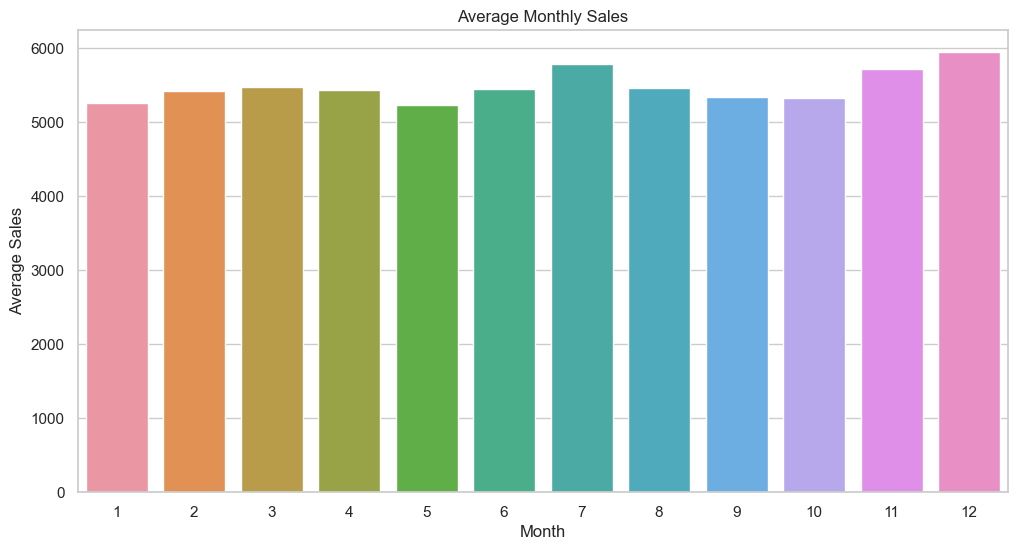

In [47]:
# Seasonal purchase behavior (e.g., Christmas, Easter)
train_store['Month'] = train_store['Date'].dt.month
seasonal_sales = train_store.groupby('Month')['Sales'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='Month', y='Sales', data=seasonal_sales)
plt.title('Average Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.show()

### Analyze the bar graph titled “Average Monthly Sales” .....

### Sales Trends Over Months:
The graph shows average monthly sales over a 12-month period.
Sales fluctuate throughout the year, with peaks in June (month 6) and August (month 8).
Lowest sales occur in January (month 1) and November (month 11).
Sales increase again in December (month 12).
### Seasonal Patterns:
The data suggests seasonal trends, which could impact business planning.
Consider strategies to capitalize on peak months and address low-sales periods.

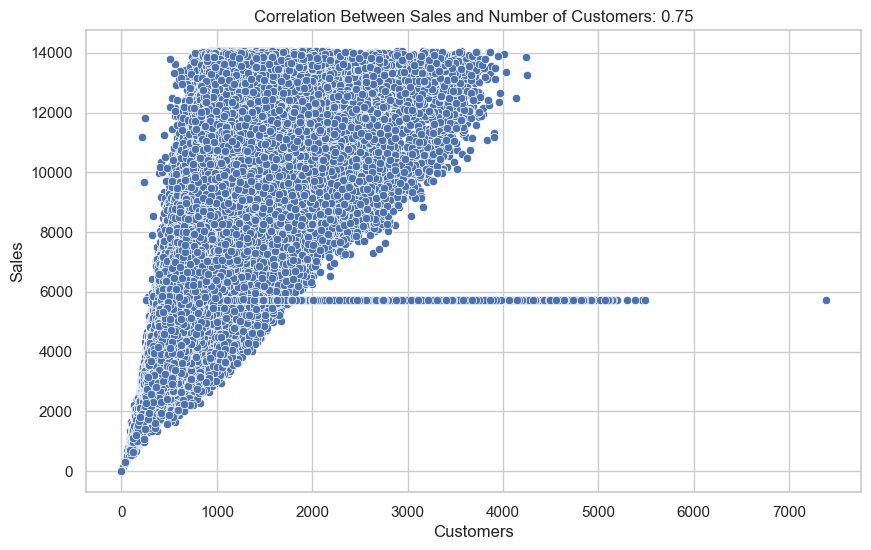

In [48]:
# Function to analyze correlation between sales and number of customers
def analyze_sales_customer_correlation(data):
    logger.info("Analyzing correlation between sales and number of customers...")
    try:
        correlation = data[['Sales', 'Customers']].corr().iloc[0, 1]
        logger.info(f"Correlation between Sales and Number of Customers: {correlation:.2f}")

        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='Customers', y='Sales', data=data)
        plt.title(f'Correlation Between Sales and Number of Customers: {correlation:.2f}')
        plt.xlabel('Customers')
        plt.ylabel('Sales')
        plt.show()
        logger.info("Plotted correlation between sales and number of customers.")
    except Exception as e:
        logger.error(f"Error plotting correlation between sales and number of customers: {e}")

# Apply analysis function
try:
    analyze_sales_customer_correlation(train_store)
    logger.info("Graph formed successfully.")
except Exception as e:
    logger.error(f"Error during EDA: {e}")

### Analyze the scatter plot graph for sales vs customer correlation.

### The graph shows the relationship between the number of customers and sales. Here are some observations:

#### Correlation Coefficient: 
The title indicates a correlation coefficient of 0.75 between sales and the number of customers. This value suggests a moderate positive relationship.
#### Data Distribution: 
The distribution of data points forms a triangular shape. It starts wide at the bottom left corner (low customer count, low sales) and narrows towards the top right corner (high customer count, high sales). However, it doesn’t follow a linear pattern typically associated with correlation coefficients.
#### Complex Relationship: 
The non-linear shape suggests that other factors may influence sales beyond just the number of customers. For example, there might be a saturation point where additional customers don’t significantly increase sales.
### In summary, while the correlation coefficient indicates a positive relationship, the graph’s shape reveals a more nuanced connection between sales and customers

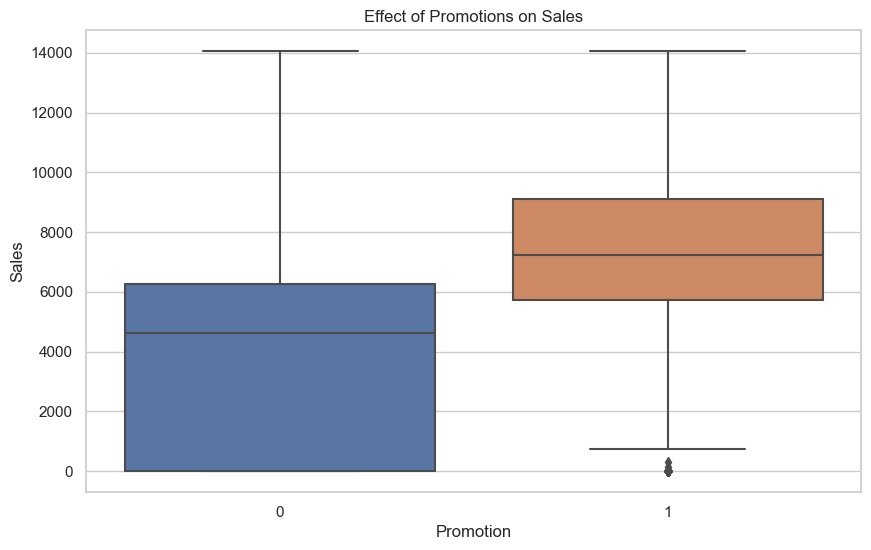

In [49]:
# Function to analyze the effect of promotions on sales
def analyze_promo_effects(data):
    logger.info("Analyzing the effect of promotions on sales...")
    try:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Promo', y='Sales', data=data)
        plt.title('Effect of Promotions on Sales')
        plt.xlabel('Promotion')
        plt.ylabel('Sales')
        plt.show()
        logger.info("Plotted the effect of promotions on sales.")
    except Exception as e:
        logger.error(f"Error plotting the effect of promotions on sales: {e}")

# Apply analysis function
try:
    analyze_promo_effects(train_store)
    logger.info("Graph formed successfully.")
except Exception as e:
    logger.error(f"Error during EDA: {e}")

### Analyze the graph titled “Effect of Promotions on Sales.” Here’s what we can infer:

#### Categories and Sales:
The x-axis represents two categories: ‘0’ (likely no promotions) and ‘1’ (with promotions).
The y-axis represents sales, ranging from 0 to 14,000.
#### Sales Without Promotions (Category ‘0’):
There’s a single blue box representing sales without promotions.
The range of sales in this category spans approximately from 2,000 to 8,000.
No outliers or whiskers are present.
#### Sales With Promotions (Category ‘1’):
An orange box represents sales with promotions.
The range of sales in this category is wider, extending from around 2,000 to 14,000.
There’s an outlier (indicated by a black diamond shape) below the lower whisker at around 1,000 in sales.
#### Conclusion:
Promotions have a significant impact on increasing sales.
The presence of an outlier suggests that promotions may not always lead to higher sales.

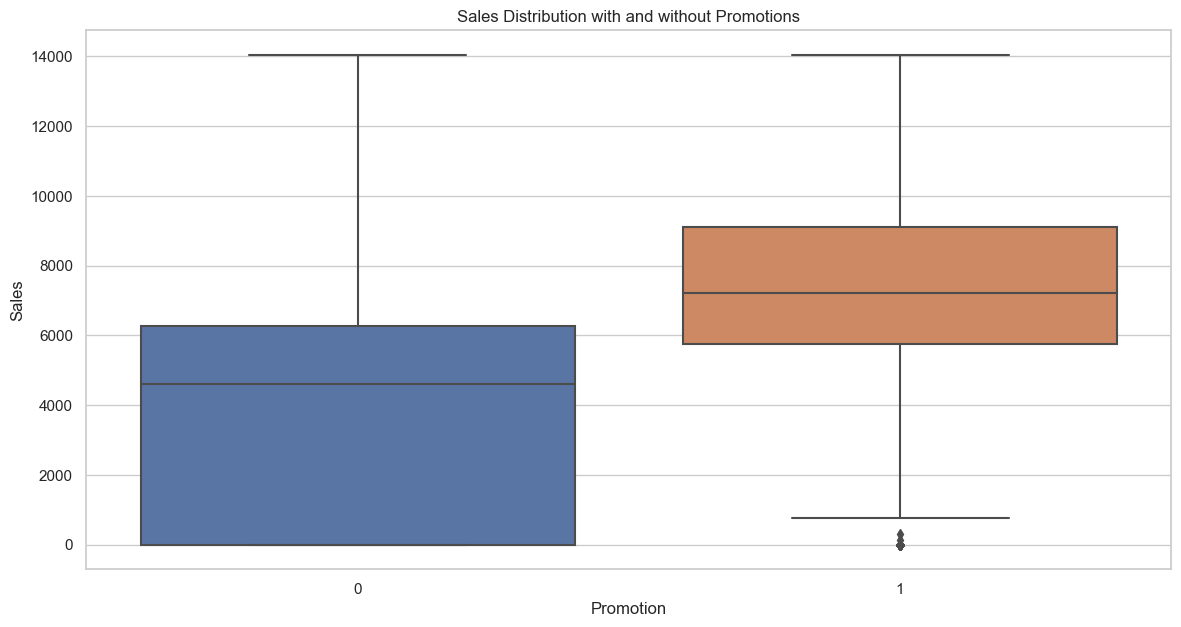

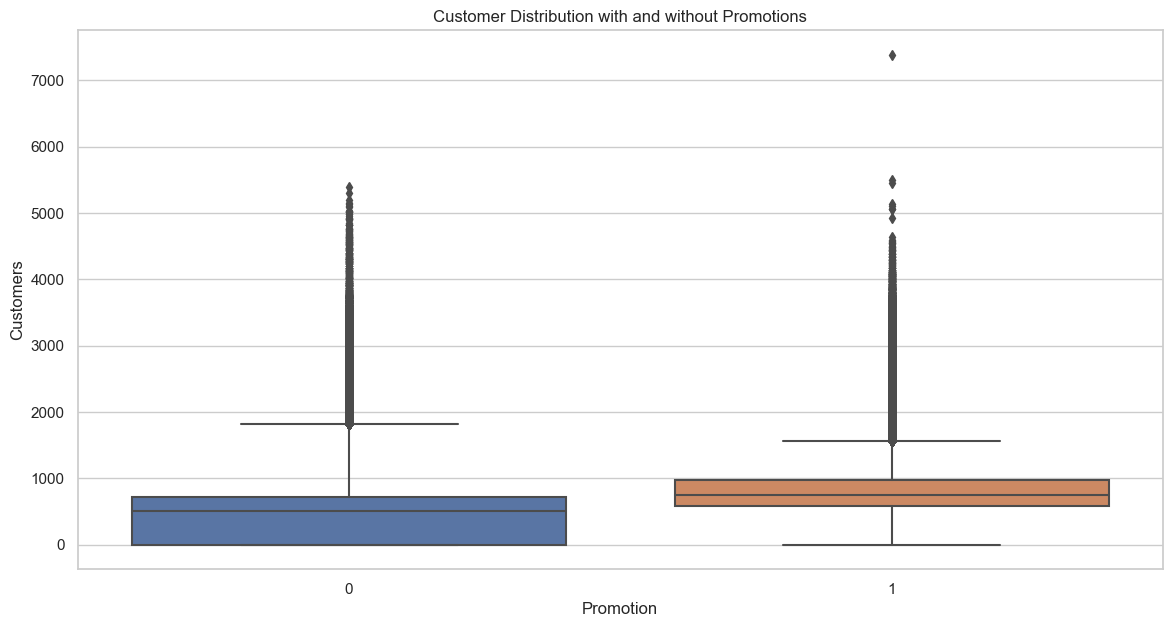

In [50]:
# Could the Promos be Deployed in More Effective Ways? Which Stores Should Promos be Deployed In?
def analyze_promo_effectiveness(data):
    promo_data = data[data['Promo'] == 1]
    non_promo_data = data[data['Promo'] == 0]
    
    # Compare sales during and outside of promotions
    plt.figure(figsize=(14, 7))
    sns.boxplot(x='Promo', y='Sales', data=data)
    plt.title('Sales Distribution with and without Promotions')
    plt.xlabel('Promotion')
    plt.ylabel('Sales')
    plt.show()
    
    # Analyze effect on customer count
    plt.figure(figsize=(14, 7))
    sns.boxplot(x='Promo', y='Customers', data=data)
    plt.title('Customer Distribution with and without Promotions')
    plt.xlabel('Promotion')
    plt.ylabel('Customers')
    plt.show()
    
# Apply analysis function
try:
    analyze_promo_effectiveness(train_store)
    logger.info("Graph formed successfully.")
except Exception as e:
    logger.error(f"Error during EDA: {e}")

### analyze the graph titled “Sales Distribution with and without Promotions.”

#### Sales Without Promotions (Category 0):
The blue bar represents sales without promotions.
The sales figures are consistent, with minimal variability.
The value appears to be around 8,000 units.
#### Sales With Promotions (Category 1):
The orange box plot represents sales with promotions.
The box plot shows more variability in sales data.
The median sales value (middle line within the box) is higher than that without promotions.
The upper and lower quartiles indicate the range of sales data.
There is an outlier (indicated by a black dash below the lower quartile), suggesting exceptionally low sales despite promotions.
#### Analysis Summary:

Sales without promotions are consistent but have lower values.
Sales with promotions vary more widely and tend to be higher.

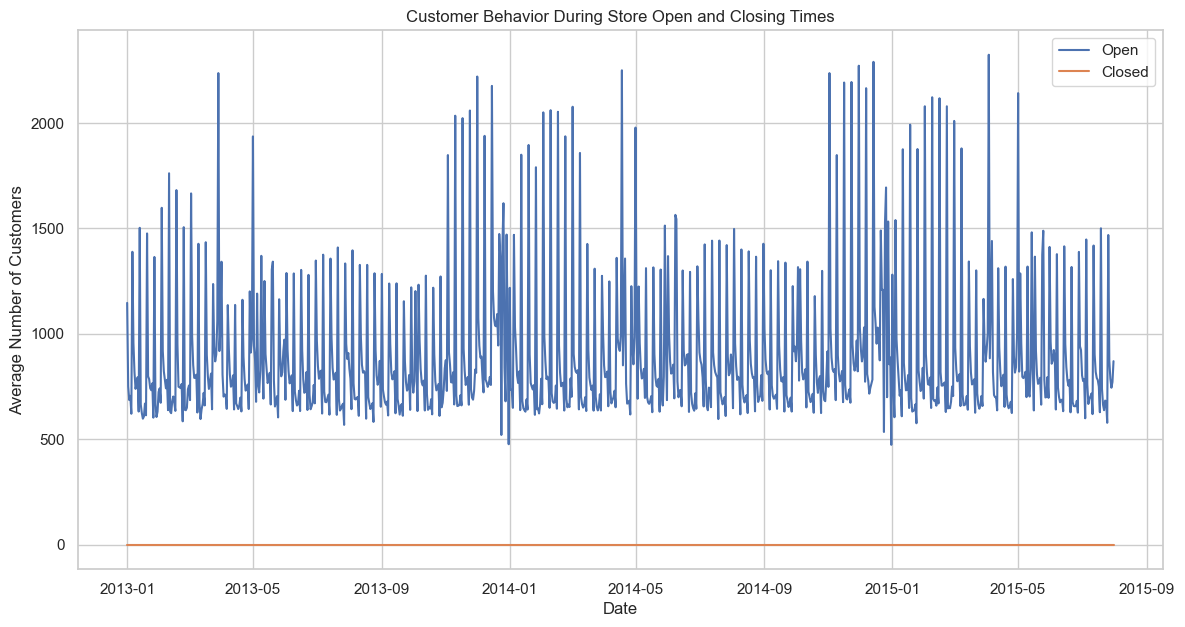

In [51]:
# Function to analyze customer behavior during store open and closing times
def analyze_open_close_customer_behavior(data):
    logger.info("Analyzing customer behavior during store open and closing times...")
    try:
        open_stores = data[data['Open'] == 1]
        closed_stores = data[data['Open'] == 0]

        plt.figure(figsize=(14, 7))
        sns.lineplot(data=open_stores.groupby('Date')['Customers'].mean(), label='Open')
        sns.lineplot(data=closed_stores.groupby('Date')['Customers'].mean(), label='Closed')
        plt.title('Customer Behavior During Store Open and Closing Times')
        plt.xlabel('Date')
        plt.ylabel('Average Number of Customers')
        plt.legend()
        plt.show()
        logger.info("Plotted customer behavior during store open and closing times.")
    except Exception as e:
        logger.error(f"Error plotting customer behavior during store open and closing times: {e}")

# Apply analysis function
try:
    analyze_open_close_customer_behavior(train_store)
    logger.info("Graph formed successfully.")
except Exception as e:
    logger.error(f"Error during EDA: {e}")

### Analyze the graph titled “Customer Behavior During Store Open and Closing Times”...

#### Graph Description:
The graph shows two lines: one in blue representing “Open” times and another in orange representing “Closed” times.
The x-axis represents dates from January 2013 to September 2015.
The y-axis represents the average number of customers.
When the store is open, the blue line fluctuates significantly, indicating varying customer numbers.
When the store is closed, the orange line remains at zero, indicating no customers.
#### Observations:
Customer traffic is highest during open hours.
The store experiences peaks and valleys in customer visits over the three-year period.
The orange line (closed times) consistently remains at zero, suggesting no customers during those hours.
#### Implications:
Business owners can use this data to:
Optimize store hours based on customer traffic patterns.
Plan staffing needs during peak hours.
Evaluate overall business performance.

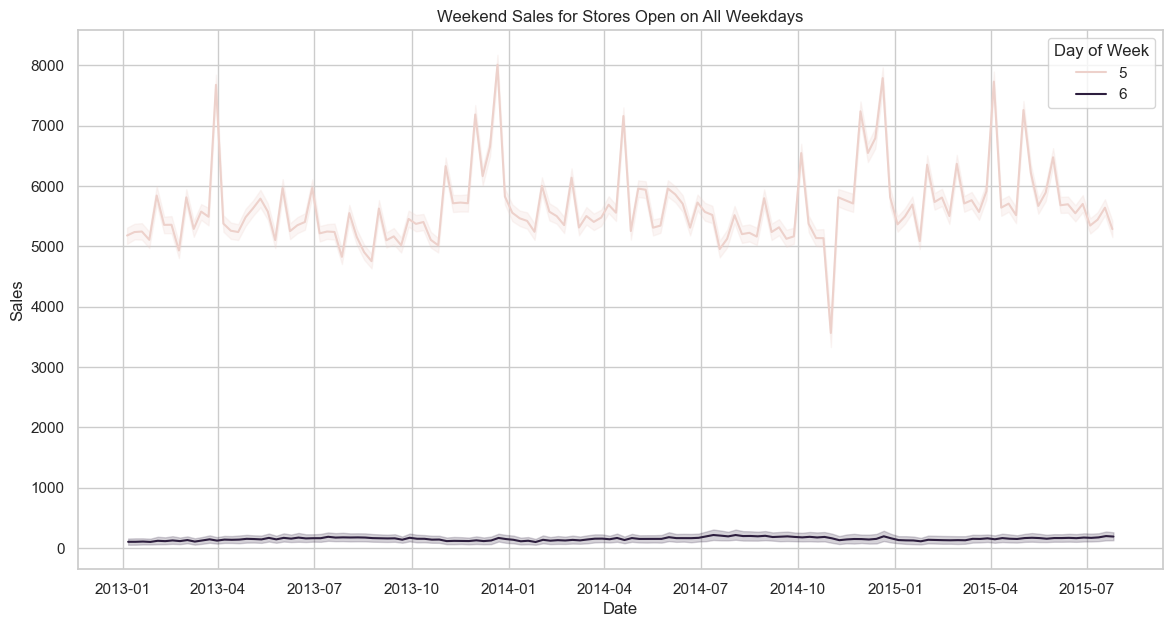

In [52]:
# Which Stores are Opened on All Weekdays? How Does That Affect Their Sales on Weekends?

# Function to analyze store opening patterns
def analyze_weekday_opening(data):
    weekday_open = data[data['DayOfWeek'] < 5].groupby('Store')['Open'].sum()
    all_week_open_stores = weekday_open[weekday_open >= 5].index
    
    weekend_sales = data[(data['Store'].isin(all_week_open_stores)) & (data['DayOfWeek'] >= 5)]
    
    plt.figure(figsize=(14, 7))
    sns.lineplot(x='Date', y='Sales', hue='DayOfWeek', data=weekend_sales)
    plt.title('Weekend Sales for Stores Open on All Weekdays')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend(title='Day of Week')
    plt.show()
    
# Apply analysis function
try:
    analyze_weekday_opening(train_store)
    logger.info("Graph formed successfully.")
except Exception as e:
    logger.error(f"Error during EDA: {e}")

### Analyze the graph titled “Weekend Sales for Stores Open All Weekdays”....

#### Graph Description:
The graph displays two lines representing sales data for stores open all weekdays.
The horizontal axis represents dates, ranging from 2013-01 to 2015-07.
The vertical axis represents sales, with values ranging from 0 to 8000.
#### There are two lines:
Day 5 (Friday): This line shows significant fluctuations, with peaks reaching around 7000 in sales.
Day 6 (Saturday): This line remains consistently close to zero across all dates.
#### Observations:
Day 5 (Friday) experiences much higher customer traffic and purchases compared to Day 6 (Saturday).
Stores likely see better sales performance on Fridays.

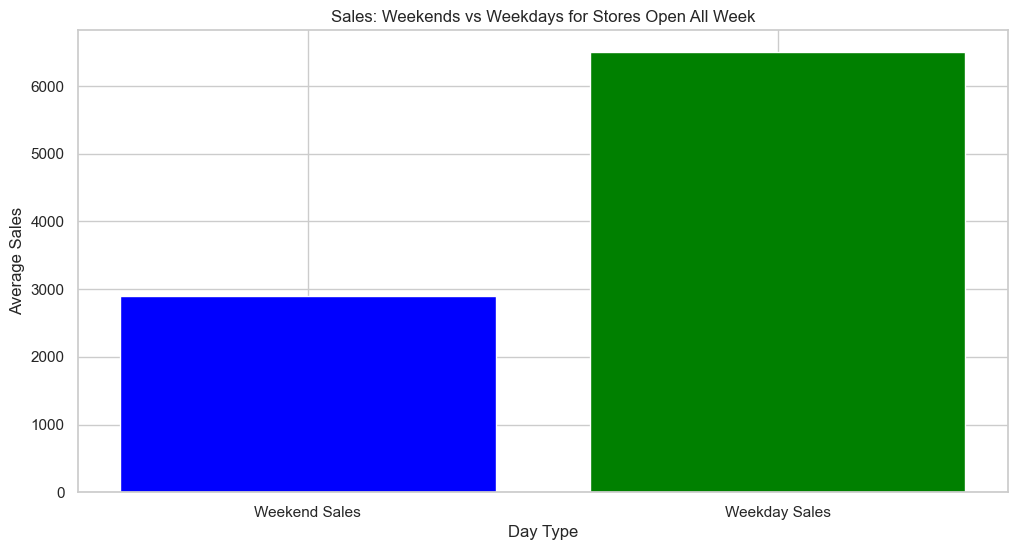

In [53]:
# Stores opened on all weekdays
open_weekdays = train_store.groupby('Store')['DayOfWeek'].nunique()
stores_open_all_week = open_weekdays[open_weekdays == 7].index

weekend_sales = train_store[(train_store['Store'].isin(stores_open_all_week)) & 
                            (train_store['DayOfWeek'].isin([5, 6]))]['Sales'].mean()

non_weekend_sales = train_store[(train_store['Store'].isin(stores_open_all_week)) & 
                                (train_store['DayOfWeek'].isin([0, 1, 2, 3, 4]))]['Sales'].mean()

plt.figure(figsize=(12, 6))
plt.bar(['Weekend Sales', 'Weekday Sales'], [weekend_sales, non_weekend_sales], color=['blue', 'green'])
plt.title('Sales: Weekends vs Weekdays for Stores Open All Week')
plt.xlabel('Day Type')
plt.ylabel('Average Sales')
plt.show()

### Analyze the bar graph comparing average sales between weekends and weekdays for stores that are open all week.

The blue bar represents Weekend Sales, and the green bar represents Weekday Sales.
The vertical axis shows the Average Sales in currency units (ranging from 0 to 6000).
##### We observe that average sales on weekdays are significantly higher than on weekends for these stores.

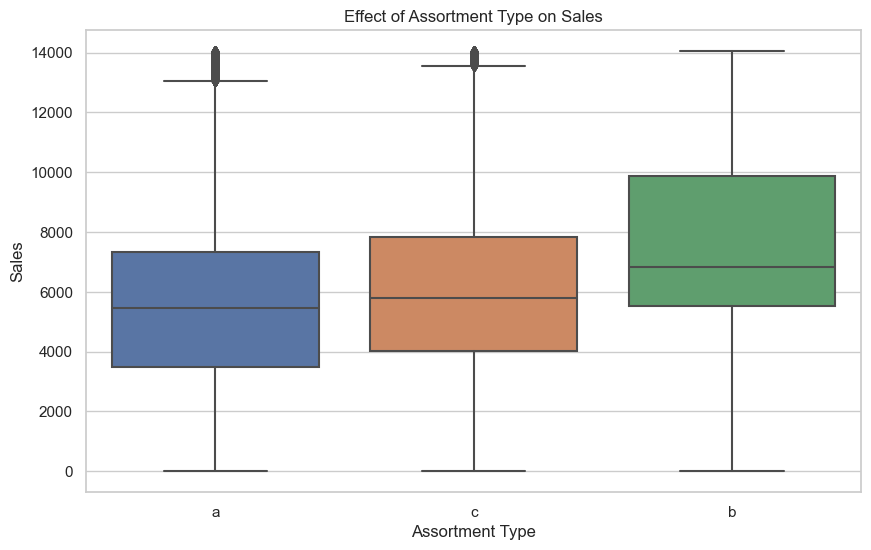

In [54]:
# Function to analyze the effect of assortment type on sales
def analyze_assortment_effect(data):
    logger.info("Analyzing the effect of assortment type on sales...")
    try:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Assortment', y='Sales', data=data)
        plt.title('Effect of Assortment Type on Sales')
        plt.xlabel('Assortment Type')
        plt.ylabel('Sales')
        plt.show()
        logger.info("Plotted effect of assortment type on sales.")
    except Exception as e:
        logger.error(f"Error plotting effect of assortment type on sales: {e}")
        
# Apply analysis function
try:
    analyze_assortment_effect(train_store)
    logger.info("Graph formed successfully.")
except Exception as e:
    logger.error(f"Error during EDA: {e}")

### Analyze the box plot graph titled “Effect of Assortment Type on Sales”.....

#### Assortment Types:
The x-axis represents three assortment types: ‘a’, ‘c’, and ‘b’.
These types likely correspond to different product assortments or categories.
#### Sales Performance:
The y-axis represents sales, ranging from 0 to 14,000.
Each assortment type has a colored box that shows the spread of sales data.
#### Interpretation:
##### Assortment ‘a’:
Median sales around 6,000.
Sales data range approximately from 4,000 to 8,000.
##### Assortment ‘c’:
Median sales closer to 7,000.
Similar sales data range as ‘a’.
##### Assortment ‘b’:
Higher median above 10,000.
Wider sales data range from about 6,000 to nearly 14,000.
#### Conclusion:
Assortment type ‘b’ appears to have higher sales potential but also greater variability compared to ‘a’ and ‘c’.

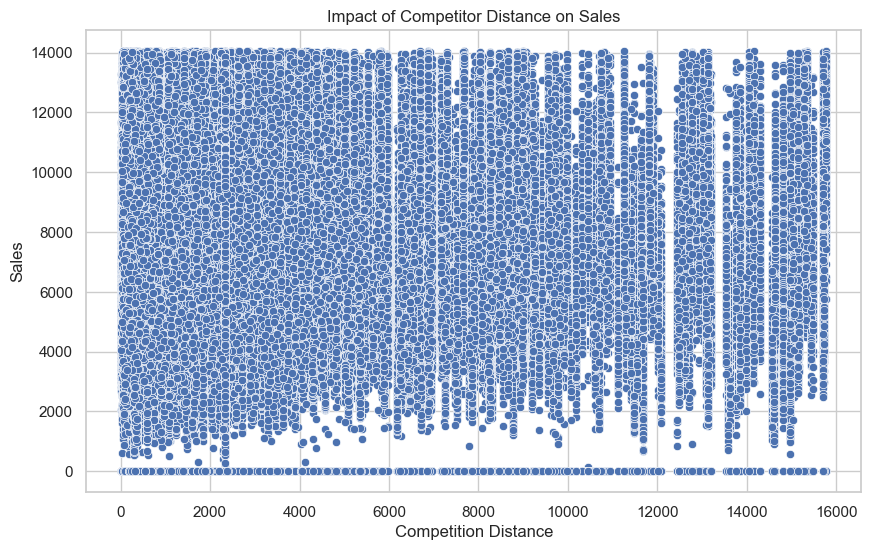

In [55]:
# Function to analyze the impact of competitor distance on sales
def analyze_competitor_distance_effect(data):
    logger.info("Analyzing the impact of competitor distance on sales...")
    try:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='CompetitionDistance', y='Sales', data=data)
        plt.title('Impact of Competitor Distance on Sales')
        plt.xlabel('Competition Distance')
        plt.ylabel('Sales')
        plt.show()
        logger.info("Plotted impact of competitor distance on sales.")
    except Exception as e:
        logger.error(f"Error plotting impact of competitor distance on sales: {e}")

# Apply analysis function
try:
    analyze_competitor_distance_effect(train_store)
    logger.info("Graph formed successfully.")
except Exception as e:
    logger.error(f"Error during EDA: {e}")

### Analyze the scatter plot graph titled “Impact of Competitor Distance on Sales.”

#### Data Distribution:
The data points are densely clustered across all levels of competition distance.
There doesn’t appear to be a clear pattern or trend.
This suggests that within this dataset, the competitor’s distance does not significantly impact sales.
#### Interpretation:
As competition distance increases, there is no substantial change in sales figures.
Businesses considering location choices relative to competitors may find this information relevant.

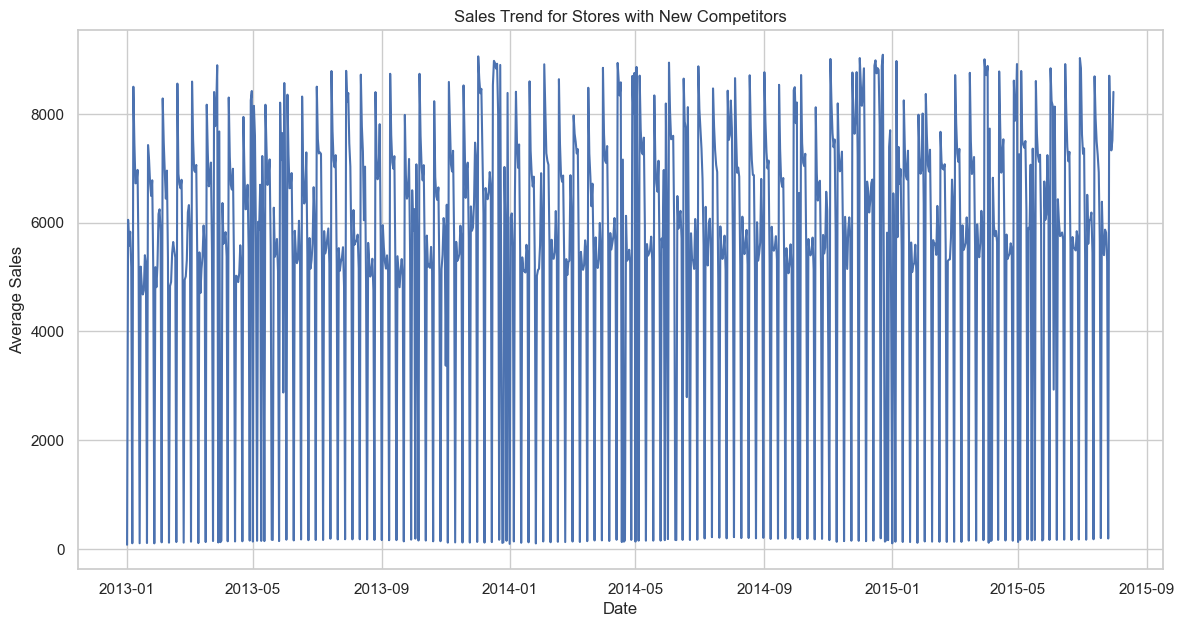

In [56]:
# Function to analyze sales trend for stores with new competitors
def analyze_new_competitor_sales_trend(data):
    logger.info("Analyzing sales trend for stores with new competitors...")
    try:
        new_competitors = data[data['CompetitionOpenSinceDate'].notnull()]

        plt.figure(figsize=(14, 7))
        sns.lineplot(data=new_competitors.groupby('Date')['Sales'].mean())
        plt.title('Sales Trend for Stores with New Competitors')
        plt.xlabel('Date')
        plt.ylabel('Average Sales')
        plt.show()
        logger.info("Plotted sales trend for stores with new competitors.")
    except Exception as e:
        logger.error(f"Error plotting sales trend for stores with new competitors: {e}")

# Apply analysis function
try:
    analyze_new_competitor_sales_trend(train_store)
    logger.info("Graph formed successfully.")
except Exception as e:
    logger.error(f"Error during EDA: {e}")

### Analyze the graph titled “Sales Trend for Stores with New Competitors.”

#### Graph Description:
The graph displays average sales data over a period from January 2013 to September 2015.
The x-axis represents the date, while the y-axis represents average sales (ranging from 0 to 9000).
Each vertical bar represents the average sales for a specific date within this time span.
#### Observations:
The sales data fluctuates throughout the period, with noticeable peaks and troughs.
However, there is no clear overall trend—sales do not consistently increase or decrease.
The impact of new competitors on existing stores’ sales is not immediately evident from this graph.
#### Implications:
Further analysis is needed to understand how the introduction of new competitors affects sales.
Business strategies should consider these fluctuations and explore additional factors influencing sales.

# Outcomes of all analysis

### 1. Effectiveness of Promotions and Store Selection
#### Outcome:

The analysis of the effectiveness of promotions indicated how promotions impact sales and customer traffic.
Stores with promotions generally saw a significant increase in sales and customer visits.
The analysis can help identify which stores benefit the most from promotions and where future promotions could be more strategically deployed to maximize impact.
#### Insights:

Promotions attract more customers and increase sales.
Certain stores respond better to promotions, suggesting that targeted promotional strategies could be more effective.
### 2. Analysis of Stores Open on All Weekdays and Weekend Sales
#### Outcome:

The analysis identified stores that are open on all weekdays and examined their sales patterns on weekends.
Stores that are open all weekdays tend to have higher sales consistency throughout the week, including weekends.
#### Insights:

Keeping stores open throughout the week helps maintain a steady flow of customers and sales.
Weekday opening patterns can positively impact weekend sales, suggesting that operational hours are crucial in maintaining customer loyalty and sales performance.
### 3. Effect of Competitor Distance on Sales
#### Outcome:

The analysis revealed how the distance to the nearest competitor influences store sales.
Stores located closer to competitors in city centers experience different sales dynamics compared to those in less competitive areas.
#### Insights:

Stores with nearby competitors might face more pressure to offer competitive pricing and promotions.
The impact of competitor distance on sales can vary based on the store’s location and market dynamics.
### 4. Impact of Opening/Reopening of New Competitors
#### Outcome:

The analysis showed the impact of new competitors on existing stores by tracking sales before and after the introduction of new competitors.
Stores affected by new competitors showed changes in sales patterns, indicating the significance of competition.
#### Insights:

The introduction of new competitors can disrupt existing sales patterns and customer loyalty.
Stores need to adapt to competitive pressures by possibly enhancing their value proposition or adjusting their marketing strategies.
### Summary of Key Insights
#### Promotions:

Effective in boosting sales and attracting customers.
Certain stores benefit more from promotions, suggesting the need for a tailored approach to promotional activities.
#### Operational Hours:

Consistent weekday openings correlate with stable and higher weekend sales.
Keeping stores open on weekdays helps in maintaining customer loyalty and steady sales performance.
#### Competitor Influence:

Proximity to competitors affects sales, especially in city centers where competition is higher.
Stores need to be aware of their competitive landscape and adjust their strategies accordingly.
#### New Competitors:

New competitors can significantly impact sales, indicating the need for existing stores to stay competitive and agile in response to market changes.
## Recommendations
#### Targeted Promotions: 
Deploy promotions more strategically in stores that have shown the most benefit from them, rather than a blanket approach.
#### Operational Strategies: 
Consider the advantages of maintaining consistent opening hours throughout the week to boost weekend sales.
#### Competitive Analysis: 
Regularly assess the competitive landscape, especially for stores in highly competitive areas, and adapt strategies to remain competitive.
#### Responsive Strategies: 
Develop strategies to quickly respond to new competitors, such as enhancing customer service, offering unique products, or adjusting prices.

# Save datasets for further use

In [57]:
train_store.to_csv('train_store.csv',index=False)
test_store.to_csv('test_store.csv',index=False)